In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import collections
from random import choices
from sklearn.metrics import accuracy_score

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.callbacks import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# convert to one-hot-encoding
from keras.utils.np_utils import to_categorical 

# Transfer learning model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import *
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

---------------

Loading Train Dataset:

In [4]:
Categories = list(os.listdir("/content/gdrive/MyDrive/Cyano/Dataset V2/Train"))
Categories

['Anabaena',
 'Aphanizomenon',
 'Cylindrospermopsis',
 'Dolichospermum',
 'Microcystis',
 'Nostoc',
 'Oscillatoria',
 'Raphidiopsis',
 'Phormidium',
 'Planktothrix']

In [5]:
images = {}
images_directory = {}
for dirname in os.listdir("/content/gdrive/MyDrive/Cyano/Dataset V2/Train"):
    dir = "/content/gdrive/MyDrive/Cyano/Dataset V2/Train/"+dirname
    if os.path.isdir(dir):
        imags = []
        imgs_directory = []
        for i, filename in enumerate(os.listdir(dir)):
          if 'jpg' in filename or 'png' in filename:
              addr = dir+"/"+filename
              image = cv2.imread(addr,0)
              image = image/255.0
              imags.append(image)
              imgs_directory.append(addr)
        images[dirname] = imags
        images_directory[dirname] = imgs_directory

In [6]:
countofallimages = 0
for cls in Categories:
  countofallimages += len(images[cls])

In [7]:
print(f'Count of all images in Dataset = {countofallimages}')
print(f'There are {len(Categories )} classes')
print(f'Average number of essential images for each class is = {round(countofallimages/len(Categories))}')

Count of all images in Dataset = 2073
There are 10 classes
Average number of essential images for each class is = 207


In [8]:
X = []
y = []
X_addr = []
for cls in Categories:
  for img in images[cls]:
    X.append(img)
    y.append(cls)
for cls in Categories:
  for img in images_directory[cls]:
    X_addr.append(img)
y = np.array(y)
X = np.array(X)
X_addr = np.array(X_addr)

In [9]:
counter = collections.Counter(y)
counter

Counter({'Anabaena': 268,
         'Aphanizomenon': 30,
         'Cylindrospermopsis': 23,
         'Dolichospermum': 130,
         'Microcystis': 895,
         'Nostoc': 237,
         'Oscillatoria': 157,
         'Phormidium': 224,
         'Planktothrix': 104,
         'Raphidiopsis': 5})

Split Train Dataset to training and validation dataset:

In [10]:
X_train_ind, X_val_ind, y_train, y_val = train_test_split(list(range(y.shape[0])), y, test_size=0.01,random_state=1)
X_train_addr = X_addr[X_train_ind]
X_train = X[X_train_ind]

X_val_addr = X_addr[X_val_ind]
X_val = X[X_val_ind]

In [11]:
counter = collections.Counter(y_val)
counter

Counter({'Anabaena': 1,
         'Aphanizomenon': 1,
         'Cylindrospermopsis': 1,
         'Dolichospermum': 2,
         'Microcystis': 11,
         'Nostoc': 1,
         'Oscillatoria': 2,
         'Phormidium': 2})

----------------------

Loading Test DataSet:

In [12]:
images = {}
images_directory = {}
for dirname in os.listdir("/content/gdrive/MyDrive/Cyano/Dataset V2/Test"):
    dir = "/content/gdrive/MyDrive/Cyano/Dataset V2/Test/"+dirname
    if os.path.isdir(dir):
        imags = []
        imgs_directory = []
        for i, filename in enumerate(os.listdir(dir)):
          if 'jpg' in filename or 'png' in filename:
              addr = dir+"/"+filename
              image = cv2.imread(addr,0)
              image = image/255.0
              imags.append(image)
              imgs_directory.append(addr)
        images[dirname] = imags
        images_directory[dirname] = imgs_directory

In [13]:
X_test = []
y_test = []
X_test_addr = []
for cls in Categories:
  for img in images[cls]:
    X_test.append(img)
    y_test.append(cls)
for cls in Categories:
  for img in images_directory[cls]:
    X_test_addr.append(img)
y_test = np.array(y_test)
X_test = np.array(X_test)
X_test_addr = np.array(X_test_addr)

In [14]:
counter = collections.Counter(y_test)
counter

Counter({'Anabaena': 57,
         'Aphanizomenon': 4,
         'Cylindrospermopsis': 3,
         'Dolichospermum': 33,
         'Microcystis': 235,
         'Nostoc': 73,
         'Oscillatoria': 32,
         'Phormidium': 61,
         'Planktothrix': 19,
         'Raphidiopsis': 2})

In [15]:
del images
del images_directory
del X
del X_val_addr
del y

------------------

Data Augmentation:

In [16]:
def generateimage(img,y,count):
    new_X_train = []
    new_y_train = []
    i = 0
    y = np.array(y).reshape((1,))

    flow = demo_datagen.flow(img.reshape((1,img.shape[0],img.shape[1],1)),y, batch_size=12)
    for batch,ind in flow:
        if i>=count:
            break
        new_X_train.append(batch.reshape((batch.shape[1],batch.shape[2])))
        new_y_train.append(ind[0])
        i+=1
    new_X_train = np.array(new_X_train)
    new_y_train = np.array(new_y_train)
    return new_X_train,new_y_train

In [17]:
def preprocessing(X_train,y_train,downsampling=True,upsampling=True):
  new_X = []
  new_y = []
  new_X_addr = []
  counter = collections.Counter(y_train)
  for cls in Categories:
    print(cls)
    if counter[cls] > np.round(np.mean(list(counter.values()))) :
      select_prob = (np.round(np.mean(list(counter.values()))) /counter[cls]) +0.3
      for ind , x in enumerate(X_train):
        if y_train[ind] == cls:
            if downsampling:
                choise = choices([1,0], [select_prob,1-select_prob])
                if choise==[1]:
                    new_X.append(x)
                    new_y.append(cls)
                    new_X_addr.append(X_train_addr[ind])
            else:
                new_X.append(x)
                new_y.append(cls)
                new_X_addr.append(X_addr[ind])



    if counter[cls] < np.round(np.mean(list(counter.values()))):
      if upsampling:
        generate_number = int(np.round(np.round(np.mean(list(counter.values()))) /counter[cls]))
        for ind , x in enumerate(X_train):
          if y_train[ind] == cls:
            n_x,n_y = generateimage(x ,y_train[ind],generate_number)
            for xx in n_x:
                new_X.append(xx)
                new_y.append(cls)
                new_X_addr.append(X_train_addr[ind])
            new_X.append(x)
            new_y.append(cls)
            new_X_addr.append(X_train_addr[ind])
      else:
        for ind , x in enumerate(X_train):
          if y_train[ind] == cls:
            new_X.append(x)
            new_y.append(cls)
            new_X_addr.append(X_train_addr[ind])
            
          
  new_X = np.array(new_X)
  new_y = np.array(new_y)
  new_X_addr = np.array(new_X_addr)
  return new_X,new_y,new_X_addr

In [18]:
demo_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    #rescale=1./255,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

In [19]:
new_X_train, new_y_train, new_X_addr = preprocessing(X_train,y_train,downsampling=True,upsampling=True)

Anabaena
Aphanizomenon
Cylindrospermopsis
Dolichospermum
Microcystis
Nostoc
Oscillatoria
Raphidiopsis
Phormidium
Planktothrix


In [20]:
counter = collections.Counter(new_y_train)
counter

Counter({'Anabaena': 267,
         'Aphanizomenon': 232,
         'Cylindrospermopsis': 220,
         'Dolichospermum': 384,
         'Microcystis': 476,
         'Nostoc': 236,
         'Oscillatoria': 310,
         'Phormidium': 222,
         'Planktothrix': 312,
         'Raphidiopsis': 210})

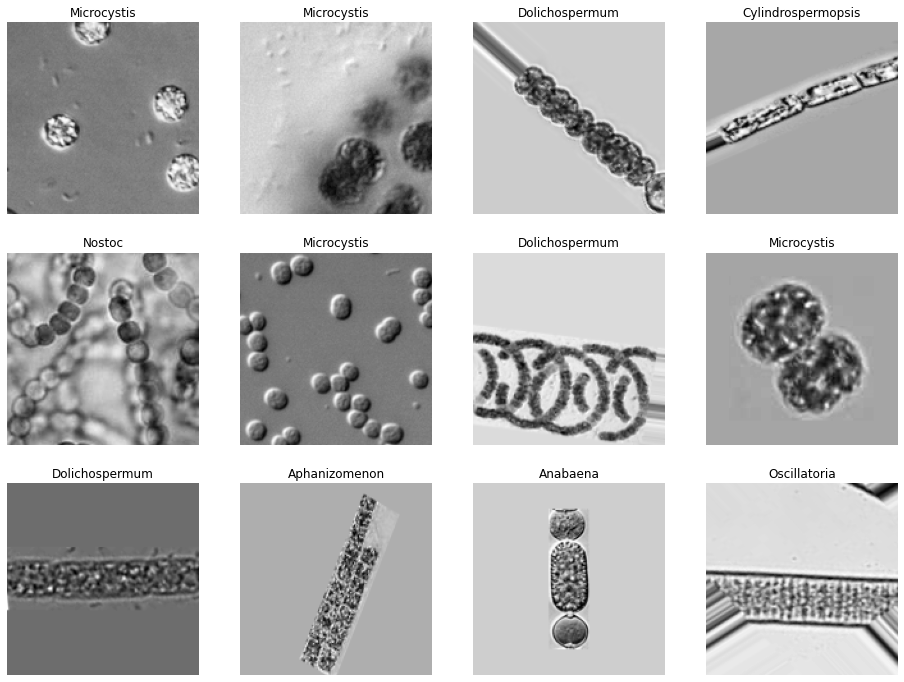

In [21]:
plt.figure(figsize=(16,12))
for n , i in enumerate(list(np.random.randint(0,len(new_X_train),12))) : 
  plt.subplot(3,4,n+1)
  plt.imshow(new_X_train[i],cmap="gray")   
  plt.axis('off')
  plt.title(new_y_train[i])

In [22]:
del X_train
del y_train

In [23]:
def Gray3channel(X):
  listt = []
  for i,x in enumerate(X):
    listt.append(cv2.merge([x,x,x]))
  return np.array(listt)

In [24]:
Gray3channel(new_X_train).shape

(2869, 150, 150, 3)

In [25]:
def ReshapeGrey(X):
  return X.reshape((X.shape[0],X.shape[1],X.shape[2],1))

In [26]:
ReshapeGrey(new_X_train).shape

(2869, 150, 150, 1)

In [27]:
encoder = LabelEncoder()
encoder.fit(new_y_train)
encoded_labels_train = encoder.transform(new_y_train)
encoded_labels_test = encoder.transform(y_test)
encoded_labels_val = encoder.transform(y_val)

OneHot_labels_train = to_categorical(encoded_labels_train,num_classes=len(Categories))
OneHot_labels_test = to_categorical(encoded_labels_test,num_classes=len(Categories))
OneHot_labels_val = to_categorical(encoded_labels_val,num_classes=len(Categories))

In [28]:
new_y_train

array(['Anabaena', 'Anabaena', 'Anabaena', ..., 'Planktothrix',
       'Planktothrix', 'Planktothrix'], dtype='<U18')

In [29]:
OneHot_labels_train.shape

(2869, 10)

------------------

In [30]:
def labelwithoutput(output):
  listt = []
  for o in output:
    listt.append(np.argmax(o))
  return np.array(listt)

# **Model 2 - MobileNetV2**

In [39]:
model =MobileNetV2(input_shape = (150, 150, 3),include_top = False, weights = 'imagenet')
for layer in model.layers[0:len(model.layers)-60]:
     layer.trainable = False
model_output = GlobalAveragePooling2D()(model.output)
model_output = Dense(32, activation='relu')(model_output)
model_output = Dense(16, activation='relu')(model_output)
model_output = Dense(10, activation='softmax')(model_output)
model=Model(inputs=[model.input],outputs=model_output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

In [41]:
def scheduler(epoch, lr):
	if epoch < 5:
		return lr
	else:
		return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [42]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
filepath = '/content/gdrive/MyDrive/Cyano/callback.h5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                save_best_only=True, 
                                verbose = 1)
model.compile(optimizer = opt,
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy'])

history = model.fit(Gray3channel(new_X_train),OneHot_labels_train, validation_data = (Gray3channel(X_val), OneHot_labels_val),epochs = 40,callbacks=[callback,checkpoint],verbose = 1)

Epoch 1/40
90/90 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.5469
Epoch 1: val_loss improved from inf to 0.68088, saving model to /content/gdrive/MyDrive/Cyano/callback.h5
90/90 [==============================] - 8s 58ms/step - loss: 0.2516 - accuracy: 0.5469 - val_loss: 0.6809 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/40
89/90 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.8097
Epoch 2: val_loss improved from 0.68088 to 0.62857, saving model to /content/gdrive/MyDrive/Cyano/callback.h5
90/90 [==============================] - 4s 44ms/step - loss: 0.1076 - accuracy: 0.8100 - val_loss: 0.6286 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/40
89/90 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.8620
Epoch 3: val_loss did not improve from 0.62857
90/90 [==============================] - 3s 37ms/step - loss: 0.0788 - accuracy: 0.8623 - val_loss: 0.9379 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 4/40
90/90 [========

In [47]:

#vggmodel.load_weights('/content/gdrive/MyDrive/Cyano/callback.h5')
vggmodel.load_weights('/content/gdrive/MyDrive/Cyano/mobilev2-92perfect.h5')

17/17 [==============================] - 0s 27ms/step - loss: 0.0694 - accuracy: 0.9287
Test Loss: 0.06939243525266647
Test Accuracy : 0.9287090301513672
                    precision    recall  f1-score   support

          Anabaena       0.88      0.91      0.90        57
     Aphanizomenon       0.50      1.00      0.67         4
Cylindrospermopsis       1.00      0.67      0.80         3
    Dolichospermum       0.91      0.88      0.89        33
       Microcystis       0.98      0.97      0.97       235
            Nostoc       0.96      0.96      0.96        73
      Oscillatoria       0.87      0.81      0.84        32
        Phormidium       0.89      0.82      0.85        61
      Planktothrix       0.79      1.00      0.88        19
      Raphidiopsis       1.00      1.00      1.00         2

          accuracy                           0.93       519
         macro avg       0.88      0.90      0.88       519
      weighted avg       0.93      0.93      0.93       519



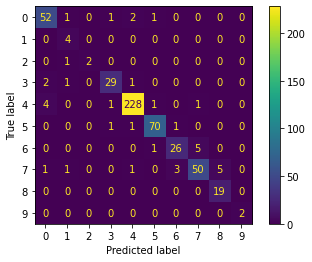

In [48]:
test_Loss, test_Acc = model.evaluate(Gray3channel(X_test),OneHot_labels_test)
print('Test Loss:', test_Loss)
print('Test Accuracy :', test_Acc)
Y_pred = model.predict(Gray3channel(X_test))
Y_pred = encoder.inverse_transform(labelwithoutput(Y_pred))
print(classification_report(y_test, Y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, Y_pred))
disp.plot()
#plt.savefig("/content/gdrive/MyDrive/Cyano/test6 (Xception).svg")
plt.show()

In [49]:
new_layer = Flatten()(model.layers[-5].output)
intermediate_layer_model = Model(inputs=model.input,
                                       outputs=new_layer)
intermediate_output_train = intermediate_layer_model.predict(Gray3channel(new_X_train))
intermediate_output_test = intermediate_layer_model.predict(Gray3channel(X_test))

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(intermediate_output_train)
X_new = pca.transform(intermediate_output_train)
X_test_new = pca.transform(intermediate_output_test)

In [51]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(objective="binary:logistic")
xgb_cl.fit(X_new, new_y_train)
Y_pred = xgb_cl.predict(X_test_new)
accuracy_score(y_test, Y_pred)
print(classification_report(y_test, Y_pred))

                    precision    recall  f1-score   support

          Anabaena       0.82      0.86      0.84        57
     Aphanizomenon       0.67      1.00      0.80         4
Cylindrospermopsis       0.50      0.67      0.57         3
    Dolichospermum       0.85      0.88      0.87        33
       Microcystis       0.92      0.97      0.94       235
            Nostoc       0.97      0.93      0.95        73
      Oscillatoria       0.96      0.78      0.86        32
        Phormidium       0.90      0.70      0.79        61
      Planktothrix       0.86      0.95      0.90        19
      Raphidiopsis       0.00      0.00      0.00         2

          accuracy                           0.90       519
         macro avg       0.74      0.77      0.75       519
      weighted avg       0.90      0.90      0.90       519



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_new, new_y_train)
Y_pred = clf.predict(X_test_new)
accuracy_score(y_test, Y_pred)
print(classification_report(y_test, Y_pred))

                    precision    recall  f1-score   support

          Anabaena       0.85      0.89      0.87        57
     Aphanizomenon       0.20      0.25      0.22         4
Cylindrospermopsis       0.67      0.67      0.67         3
    Dolichospermum       0.85      0.88      0.87        33
       Microcystis       0.99      0.98      0.99       235
            Nostoc       0.96      0.92      0.94        73
      Oscillatoria       0.79      0.84      0.82        32
        Phormidium       0.85      0.72      0.78        61
      Planktothrix       0.58      0.79      0.67        19
      Raphidiopsis       0.00      0.00      0.00         2

          accuracy                           0.90       519
         macro avg       0.67      0.69      0.68       519
      weighted avg       0.90      0.90      0.90       519



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_new, new_y_train)
Y_pred = neigh.predict(X_test_new)
accuracy_score(y_test, Y_pred)

0.9171483622350675

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_new, new_y_train)
Y_pred = clf.predict(X_test_new)
accuracy_score(y_test, Y_pred)

0.8998073217726397

In [52]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')
clf.fit(X_new, new_y_train)
Y_pred = clf.predict(X_test_new)
print(accuracy_score(y_test, Y_pred))
print(classification_report(y_test, Y_pred))

0.9325626204238922
                    precision    recall  f1-score   support

          Anabaena       0.90      0.93      0.91        57
     Aphanizomenon       0.67      1.00      0.80         4
Cylindrospermopsis       1.00      0.67      0.80         3
    Dolichospermum       0.94      0.88      0.91        33
       Microcystis       0.98      0.97      0.97       235
            Nostoc       0.95      0.97      0.96        73
      Oscillatoria       0.81      0.81      0.81        32
        Phormidium       0.89      0.84      0.86        61
      Planktothrix       0.83      1.00      0.90        19
      Raphidiopsis       1.00      1.00      1.00         2

          accuracy                           0.93       519
         macro avg       0.90      0.91      0.89       519
      weighted avg       0.93      0.93      0.93       519



In [44]:
#model.save_weights('/content/gdrive/MyDrive/Cyano/mobilev2-92perfect.h5')

-----------------------------